### Hyperparameters to reproduce results of paper "Computing the untruncated signature kernel..."

In [1558]:
# name, scale, rbf, sigma, ll, at = 'ArticularyWordRecognition', 1e-1, True, 6e-1, False, False
# name, scale, rbf, sigma, ll, at = 'BasicMotions', 1e-1, True, 7e1, False, False
# name, scale, rbf, sigma, ll, at = 'Cricket', 1e-1, True, 1e0, False, False # subsample_len every 10 time steps
# name, scale, rbf, sigma, ll, at = 'Epilepsy', 1e-1, True, 1e0, False, False
# name, scale, rbf, sigma, ll, at = 'ERing', 1e-2, True, 9e-2, False, True
# name, scale, rbf, sigma, ll, at = 'Heartbeat', 1e-1, True, 1e1, False, True
# name, scale, rbf, sigma, ll, at = 'Libras', 1e-1, True, 3e-2, False, False
# name, scale, rbf, sigma, ll, at = 'NATOPS', 1e-1, True, 2.25e-1, False, True
# name, scale, rbf, sigma, ll, at = 'RacketSports', 1e-1, True, 1e1, False, False
# name, scale, rbf, sigma, ll, at = 'SelfRegulationSCP1', 1e-1, True, 2.5e2, False, False # subsample_len every 2 time steps
name, scale, rbf, sigma, ll, at = 'UWaveGestureLibrary', 1e0, True, 3.5e1, False, True # subsample_len every 5 time steps

In [1559]:
import base

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import notebook as tqdm
import matplotlib.pyplot as plt
import torch 

import iisignature

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tslearn.datasets import UCR_UEA_datasets
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from tslearn.svm import TimeSeriesSVC

from transformers_sig import AddTime, LeadLag

from sigKer_fast import sig_kernel_Gram_matrix 

In [1560]:
def transform(paths, scale=1., at=False, ll=False):
    paths = scale*paths
    if ll:
        paths = LeadLag().fit_transform(paths)
    if at:
        paths = AddTime().fit_transform(paths)
    return np.array(paths)

In [1561]:
data = UCR_UEA_datasets().list_multivariate_datasets()

In [1562]:
X_train, Y_train, X_test, Y_test = UCR_UEA_datasets(use_cache=True).load_dataset(name)

In [1563]:
subsample = 1
subsample_len = 10

x_train = X_train[::subsample,::subsample_len,:]
y_train = Y_train[::subsample]
x_test = X_test[::subsample,::subsample_len,:]
y_test = Y_test[::subsample]

# x_train = TimeSeriesScalerMinMax().fit_transform(x_train)
# x_train = TimeSeriesScalerMeanVariance().fit_transform(x_train)
# x_test = TimeSeriesScalerMinMax().fit_transform(x_test)
# x_test = TimeSeriesScalerMeanVariance().fit_transform(x_test)

y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)

print(x_train.shape)
print(x_test.shape)

(120, 32, 3)
(320, 32, 3)


In [1564]:
x_train = transform(x_train, scale, at, ll)
x_test = transform(x_test, scale, at, ll)

0


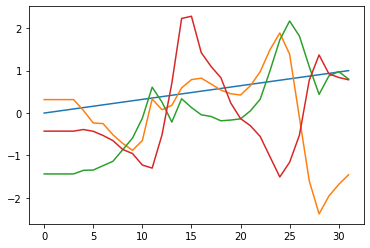

In [1565]:
k=0
plt.plot(x_train[k])
print(y_train[k])
plt.show()

In [1566]:
print(f'classes: {np.unique(y_train)}')

classes: [0 1 2 3 4 5 6 7]


In [1567]:
n,solver =  0,0

In [1568]:
gram_matrix = sig_kernel_Gram_matrix(x_train, x_train, n, solver, sym=True, rbf=rbf, sigma=sigma)

In [1569]:
test_matrix = sig_kernel_Gram_matrix(x_train, x_test, n, solver, sym=False, rbf=rbf, sigma=sigma)

In [1570]:
# gram_matrix

In [1571]:
svc_parameters = {'C': np.logspace(0, 3, 4), 'gamma': np.logspace(-3, 3, 7)}

In [1572]:
svc = TimeSeriesSVC(kernel='precomputed', decision_function_shape='ovo')

svc_model = GridSearchCV(estimator=svc, 
                         param_grid=svc_parameters, 
                         cv=TimeSeriesSplit(n_splits=5),
                         n_jobs=-1)

In [1573]:
svc_model.fit(gram_matrix, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=TimeSeriesSVC(C=1.0, cache_size=200, class_weight=None,
                                     coef0=0.0, decision_function_shape='ovo',
                                     degree=3, gamma='auto',
                                     kernel='precomputed', max_iter=-1,
                                     n_jobs=None, probability=False,
                                     random_state=None, shrinking=True,
                                     tol=0.001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([   1.,   10.,  100., 1000.]),
                         'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [1574]:
predictions = svc_model.predict(test_matrix.T)

In [1575]:
svc_model.score(test_matrix.T, y_test)

0.9

In [1576]:
# print(classification_report(predictions, y_test))

In [1577]:
# confusion_matrix(predictions, y_test)

In [1578]:
final = {}

In [1579]:
# sig-PDE kernel
final['sig-ker-PDE'] = svc_model.score(test_matrix.T, y_test)

In [1580]:
# linear and rbf kernels
for ker in tqdm.tqdm(['linear', 'rbf']):
    
    svc = TimeSeriesSVC(kernel=ker, gamma='auto', decision_function_shape='ovo')

    svc_model = GridSearchCV(estimator=svc, 
                             param_grid=svc_parameters, 
                             cv=TimeSeriesSplit(n_splits=5),
                             n_jobs=-1)
    
    svc_model.fit(x_train, y_train)
    
    final[ker] = svc_model.score(x_test, y_test)

In [1583]:
# global alignement kernel (GAK)
for gamma in tqdm.tqdm([1., 0.1, 0.01, 'auto']):
            
    svc = TimeSeriesSVC(kernel='gak', gamma=gamma, decision_function_shape='ovo')

    svc_model = GridSearchCV(estimator=svc, 
                             param_grid=svc_parameters, 
                             cv=TimeSeriesSplit(n_splits=5),
                             n_jobs=-1)

    svc_model.fit(x_train, y_train)

    final[f'gak_{gamma}'] = svc_model.score(x_test, y_test)

In [1581]:
# truncated signature kernel
for d in tqdm.tqdm(range(2,5)):
    
    svc = TimeSeriesSVC(kernel='linear', decision_function_shape='ovo')

    svc_model = GridSearchCV(estimator=svc, 
                             param_grid=svc_parameters, 
                             cv=TimeSeriesSplit(n_splits=5),
                             n_jobs=-1)

    sig_train = iisignature.sig(x_train, d)
    sig_test = iisignature.sig(x_test, d)

    svc_model.fit(sig_train, y_train)

    final[f'sig-ker-{d}'] = svc_model.score(sig_test, y_test)

In [1584]:
final

{'sig-ker-PDE': 0.9,
 'linear': 0.79375,
 'rbf': 0.840625,
 'sig-ker-2': 0.809375,
 'sig-ker-3': 0.7625,
 'sig-ker-4': 0.775,
 'gak_1.0': 0.890625,
 'gak_0.1': 0.890625,
 'gak_0.01': 0.890625,
 'gak_auto': 0.890625}

In [1585]:
final_csv = pd.DataFrame.from_dict(final, orient='index').rename(columns={0:'accuracy (%)'})
final_csv.to_csv(f'../results/{name}.csv')